# How to use the MNIST256 data set

In [1]:
import torch
import torchvision
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-rdqd9xb4 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
device = "cuda"

## Load the data 

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Grayscale()])

trainset = ImageFolder('mnist256/train', transform = transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8)

valset = ImageFolder('mnist256/val', transform = transform)
valloader = DataLoader(valset, batch_size=128, shuffle=True, num_workers=8)

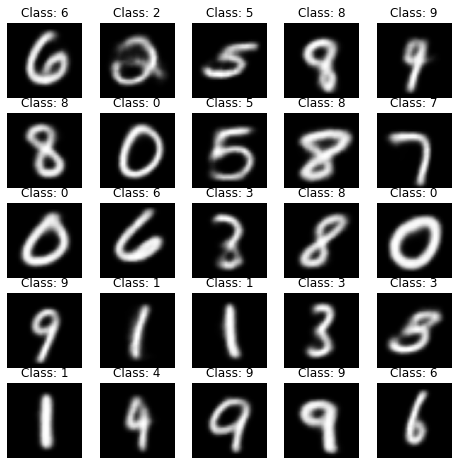

In [4]:
# visualize examples from the training data
fix, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        img, c = iter(trainloader).__next__()
        axs[i,j].imshow(img[0, 0, :, :], cmap='gray', interpolation='none')
        axs[i,j].set_title(f'Class: {c[0]}')
        axs[i,j].axis('off')
plt.show()

## Train a model

In [5]:
model = torchvision.models.resnet18()
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # a single input channel
model.fc = torch.nn.Linear(512, 10) # 10-class problem
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
ce_loss = torch.nn.CrossEntropyLoss()

In [8]:
for i_epoch in range(5):    
    model.train()
    train_loss, train_zero_one_loss = 0, 0
    for img, label in tqdm(trainloader):
        img, label = img.to(device), label.to(device)
        pred = model(img)
        optimizer.zero_grad()
        loss = ce_loss(pred, label)
        loss.backward()
        train_loss += loss.item()  
        train_zero_one_loss += (pred.softmax(dim=1).argmax(dim=1) != label).sum().item()
        optimizer.step()
    print(f'Epoch {i_epoch}: Train Loss: {train_loss / len(trainloader.dataset)}  Train Error: {train_zero_one_loss / len(trainloader.dataset)}')
    model.eval()
    test_loss, test_zero_one_loss = 0, 0
    for img, label in valloader:
        img, label = img.to(device), label.to(device)
        pred = model(img)
        test_loss += loss.item()  
        test_zero_one_loss += (pred.softmax(dim=1).argmax(dim=1) != label).sum().item()
    print(f'Epoch {i_epoch}: Test Loss: {test_loss / len(trainloader.dataset)}  Test Error: {test_zero_one_loss / len(trainloader.dataset)}')

100%|██████████| 469/469 [01:28<00:00,  5.30it/s]

Epoch 0: Train Loss: 0.0006786349698745956  Train Error: 0.029583333333333333



  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 0: Test Loss: 7.908633425831795e-05  Test Error: 0.007666666666666666


100%|██████████| 469/469 [01:28<00:00,  5.29it/s]

Epoch 1: Train Loss: 0.0005473700099779913  Train Error: 0.023783333333333333



  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Test Loss: 0.00011091891936957836  Test Error: 0.004383333333333334


 17%|█▋        | 78/469 [00:16<01:20,  4.86it/s]


KeyboardInterrupt: 

## Compute explanations

In [ ]:
model.eval()
for img, label in valloader:
    img, label = img.to(device), label.to(device)

## Evaluate the alignment of explanations with the tangent space